max 0 s 20.0
max 21 s 20.0
max 42 s 20.0
max 63 s 20.0
max 84 s 20.0
max 105 s 20.0
max 126 s 20.0
max 147 s 20.0
max 168 s 20.0
max 189 s 20.0
max 210 s 20.0
max 231 s 20.0
max 252 s 20.0
max 273 s 20.0
max 294 s 20.0
max 315 s 20.0
max 336 s 20.0
max 357 s 20.0
max 378 s 20.003274908715515
max 399 s 20.005441446254462
max 420 s 20.00975505862245
max 441 s 20.011811485545614
max 462 s 20.01562772198774
max 483 s 20.017582554441187
max 504 s 20.020989773277066
max 525 s 20.02550689250646
max 546 s 20.030120950440562
max 567 s 20.035061410407597
max 588 s 20.039321494542772
max 609 s 20.043897370689976
max 630 s 20.047853268331348
max 651 s 20.052106998486668
max 672 s 20.055798425107312
max 693 s 20.05976585755973
max 714 s 20.063745561995454
max 735 s 20.069071919156777
max 756 s 20.07417305886333
max 777 s 20.079169342919645
max 798 s 20.083980744166404
max 819 s 20.088681754998564
max 840 s 20.093230225645776
max 861 s 20.097665575632472
max 882 s 20.101974333224227
max 903 s 20.106

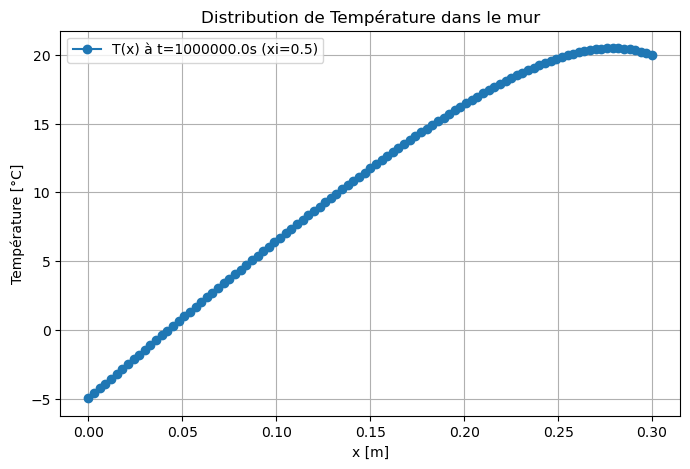

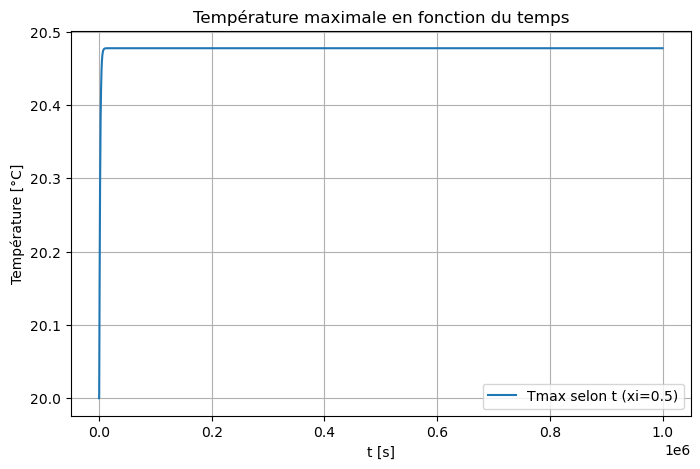

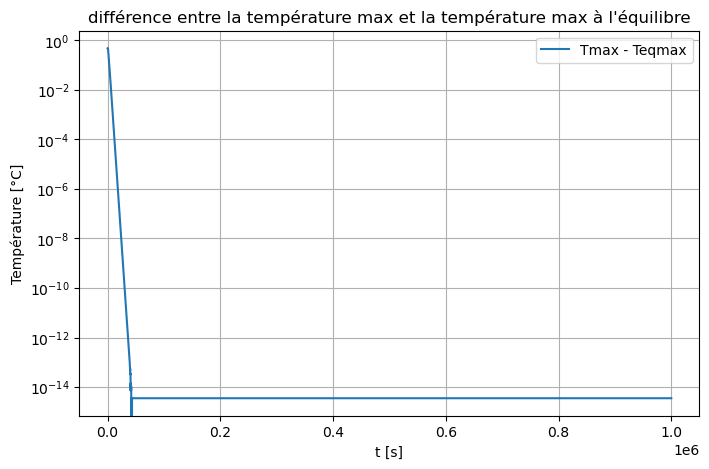

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# Paramètres du problème
# =============================================================================
L     = 0.30         # Épaisseur du mur [m]
Nx    = 100           # Nombre d'intervalles spatiaux => Nx+1 nœuds
dx    = L / Nx       # Pas d'espace
x     = np.linspace(0, L, Nx+1)

k     = 0.85        # Conductivité thermique [W/(m*K)]
h     = 20       # Coefficient de convection [W/(m^2*K)]
rho   = 2000.0       # Masse volumique [kg/m^3]
C_v   = 1000.0       # Capacité thermique massique [J/(kg*K)]
q     = 2000.0       # Taux volumique d’émission de chaleur [W/m^3]
dL    = 0.05         # Longueur caractéristique pour moduler la source
T_a   = -10.0        # Température ambiante extérieure [°C]
T_i   = 20.0         # Température imposée à x=L [°C]

dt     = 21   # Pas de temps [s]
t_final= 1000000      # Durée totale de simulation [s]
nSteps = int(t_final/dt)

xi     = 0.5       # xi=0.5 => Crank–Nicolson ; xi=1 => implicite total.

# =============================================================================
# Condition initiale
# =============================================================================
T_w = ( (k/L)*T_i + h*T_a ) / ( (k/L) + h )
T   = T_w + (T_i - T_w)*(x/L)

# =============================================================================
# Construction du Laplacien "classique" 1D
# =============================================================================
Lap = np.zeros((Nx+1, Nx+1))
for i in range(1, Nx):
    Lap[i, i-1] =  1.0
    Lap[i, i]   = -2.0
    Lap[i, i+1] =  1.0
# Les conditions aux limites seront ajustées dans la boucle en temps.
vect_max = []
vect_time = []
# =============================================================================
# Boucle en temps
# =============================================================================
for n in range(nSteps):
    # Coeffs utiles
    coeffM  = (C_v * rho) / dt
    coeffCN = (k / (dx*dx)) * dt
    
    # A_prime = M - xi*dt*k*Lap / dx^2
    A_prime = coeffM * np.eye(Nx+1) - ( xi * coeffCN ) * Lap
    
    # b_vec = M*T^n + (1-xi)*dt*k*Lap/dx^2 * T^n  +  S(x)*dt
    b_vec   = coeffM * T
    b_vec  += ( (1.0 - xi)* coeffCN ) * (Lap @ T)
    
    # Terme source
    Sx = q / (1 + ((x - L)/dL)**2)  
    b_vec += Sx * dt
    

    # Condition de convection (Robin) à x=0
    A_prime[0, :] = 0.0
    A_prime[0, 0] = coeffM + xi * coeffCN * (k/dx + h) / k
    A_prime[0, 1] = - xi * coeffCN * (k/dx) / k
    b_vec[0]      = ( coeffM*T[0]
                      + (1.0 - xi)* coeffCN*(Lap[0,:] @ T)
                      + (Sx[0]*dt)
                      + xi * coeffCN * (h*T_a)/k )
    
    # Condition de Dirichlet T(L) = T_i
    A_prime[Nx, :]  = 0.0
    A_prime[Nx, Nx] = 1.0
    b_vec[Nx]       = T_i
    
    # Résolution
    T_new = np.linalg.solve(A_prime, b_vec)
    
    max = np.max(T_new)
    time = n*dt
    print("max", time,"s" ,max)
    vect_max.append(max)
    vect_time.append(time)
    # Mise à jour
    T = T_new

# =============================================================================
# Affichage
# =============================================================================
plt.figure(figsize=(8,5))
plt.plot(x, T, 'o-', label=f'T(x) à t={t_final:.1f}s (xi={xi})')
plt.xlabel('x [m]')
plt.ylabel('Température [°C]')
plt.title('Distribution de Température dans le mur')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(vect_time, vect_max , label=f'Tmax selon t (xi={xi})')
plt.xlabel('t [s]')
plt.ylabel('Température [°C]')
plt.title('Température maximale en fonction du temps')
plt.legend()
plt.grid(True)
plt.show()

diff = []
for i in vect_max:
    diff.append(np.abs(i-20.4772251301931405))


plt.figure(figsize=(8,5))
plt.plot(vect_time, diff , label=f'Tmax - Teqmax')
plt.xlabel('t [s]')
plt.ylabel('Température [°C]')
plt.yscale('log')
plt.title("différence entre la température max et la température max à l'équilibre")
plt.legend()
plt.grid(True)
plt.show()